In [2]:
# Load the data
import csv
import numpy as np
from pprint import pprint
import os

path = os.listdir("./raw_data")[0]
with open(f"./raw_data/{path}") as fin:
    reader = csv.reader(fin, delimiter=",")
    raw_data = list(reader)

    def convert(raw_data):
        return -1 if raw_data == "" else int(raw_data)

    data = []
    for row in raw_data[1:]:
        data.append([])
        for col in range(3, len(raw_data[0]) - 2):
            data[-1].append(convert(row[col]))
    
    mat = np.array(data).T

print(mat, mat.shape)
print(np.sum(mat == -1))

[[-1  7  5 ...  4  2  3]
 [-1  5  2 ...  1  2  6]
 [-1 -1 -1 ...  1 -1 -1]
 ...
 [ 7  1  4 ...  7 -1  4]
 [-1  3  6 ...  3 -1 -1]
 [-1  1  3 ...  2 -1 -1]] (50, 65)
325


In [3]:
# Get food labels
import re

pattern = r".*?\[(.*)].*"
food_labels = [re.findall(pattern, header)[0] for header in raw_data[0][3:-2]]

In [4]:
import numpy as np
def test():
    M = [[3, 10, 2, 9, 3, -1, -1, 4],
         [3, -1, -1, 4, 9, 2, 3, 1],
         [4, -1, 2, 4, 3, 5, 1, -1],
         [-1, -1, -1, 8, 0, 2, -1, 1],
         [1, 1, -1, 1, 2, 2, -1, -1],
         [4, 4, 4, -1, -1, 10, 10, 10]]
    M = np.array(M, dtype="float")
    return matrixComplete(M, -1, 100000)
    
def matrixComplete(M, missingLabel, steps=1000):
    missing = (M == missingLabel)
    predictions = np.where(missing, np.random.random(size=M.shape), 0)
    rate = 0.01 # totally unused but good for experiments I think
    i = 0
    while True:
        i += 1
        predictedMatrix = np.where(missing, predictions, M)
        if i == steps: return predictedMatrix
        u,s,vT = np.linalg.svd(predictedMatrix)
        if i%(steps//20)==0: print(np.sum(np.abs(s)), rate)
        diag = np.zeros((u.shape[0], vT.shape[0]))
        for j in range(min(diag.shape)): diag[j,j] = 1.0
        derivative = np.where(missing, u @ diag @ vT, 0)
        predictions -= 0.1*derivative
        
        while NuclearNorm(predictedMatrix - rate*derivative) >\
           NuclearNorm(predictedMatrix):
            rate /= 1.1
        else:
            rate *= 1.05

def NuclearNorm(M):
    u,s,v = np.linalg.svd(M)
    return np.sum(np.abs(s))

In [5]:
# Clean up the data a little
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

mean = np.nanmean(mat)
n_foods, n_people = mat.shape

print(f"Mean of nonzero entries: {mean}")
print(f"Count of nonzero entries: {np.count_nonzero(~np.isnan(data))}")

print("Number of entries to fill", np.sum(mat == -1))
mat = matrixComplete(mat, -1, 1000)

# Normalize
# Standardize features?
def fit_rows(mat):
    return StandardScaler().fit_transform(mat)

def fit_cols(mat):
    return StandardScaler().fit_transform(mat.T).T

for i in range(10):
    mat = fit_rows(mat)
    mat = fit_cols(mat)

np.set_printoptions(threshold=np.inf)

# for row in mat.T[:10]:
#     print(np.mean(row), np.var(row))

Mean of nonzero entries: 3.9033846153846152
Count of nonzero entries: 3250
Number of entries to fill 325
781.4364180616798 0.10921333129289235
760.8445398630801 1.2523929318695617
747.7588010766165 14.361690438600458
739.4646749059606 32.58328500765888
734.125536670859 34.4859895107709
730.6275558944415 36.49980265210989
728.3183475796835 35.119284211632895
726.7925083644373 37.17007866651486
725.783243997407 39.340629488606034
725.1128271640657 41.63792986410954
724.6643201596022 44.06938134710399
724.361765318917 46.64281770623065
724.1559890102294 44.87866378537278
724.0149904396258 47.49935828127787
723.9177453473784 50.27308851981809
723.8502949729666 48.37162821815996
723.8032790894576 51.1962947553713
723.7704765235725 0.23686631372325326
723.7475122162613 0.14151256891660552


In [8]:
# Let's do some PCA!
from sklearn.decomposition import PCA
import json

pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

pc_2 = pca_2d.fit_transform(mat)
pc_3 = pca_3d.fit_transform(mat)

with open("../visualization/data/food_3d_points.json", "w") as fout:
    json.dump({
        "points": pc_3.tolist(),
        "labels": food_labels
    }, fout)

8

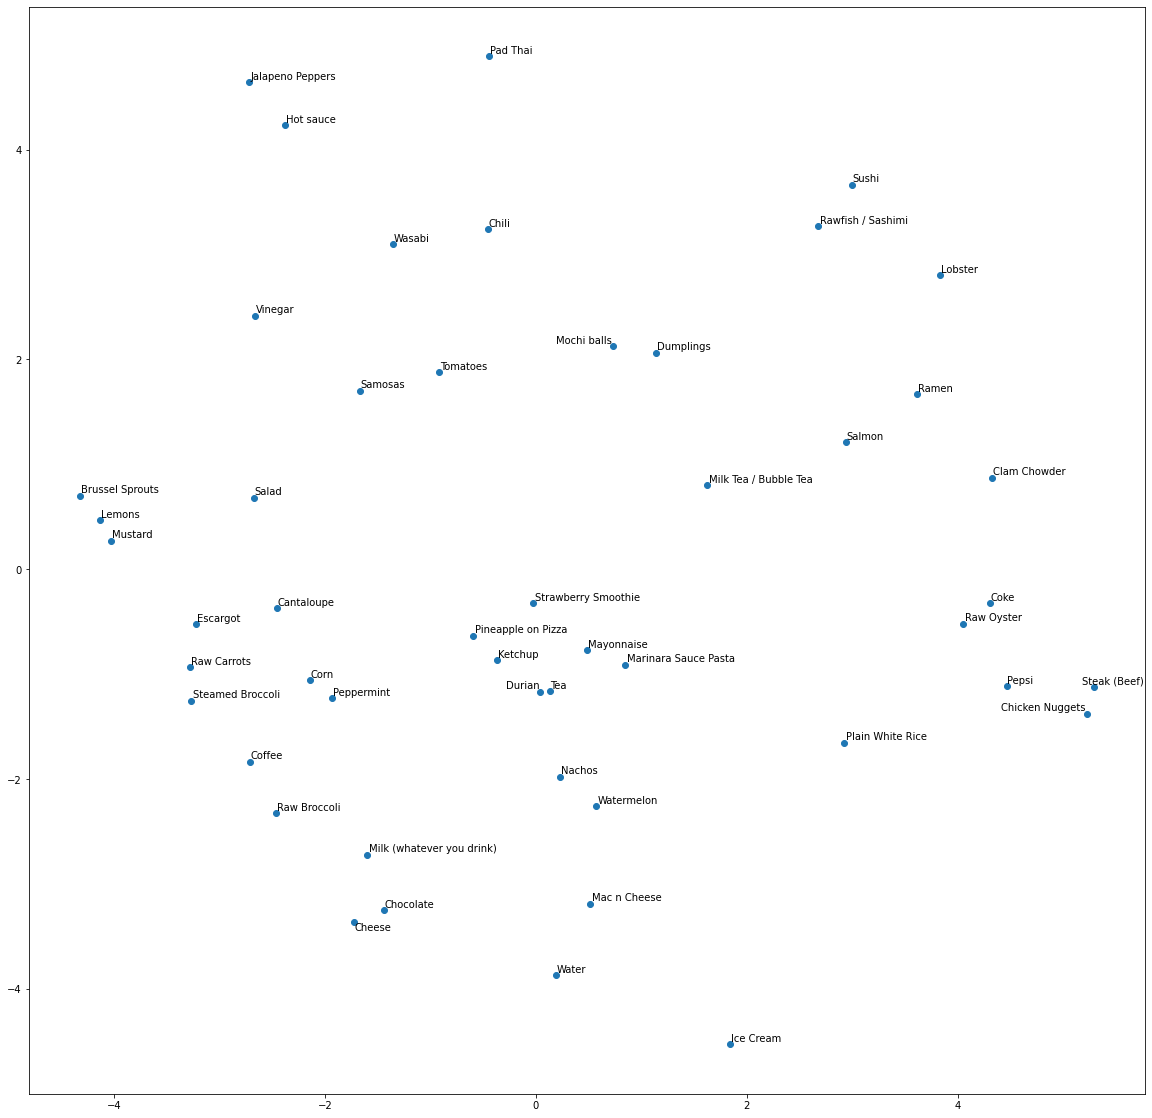

In [11]:
from matplotlib import pyplot as plt
from adjustText import adjust_text

fig = plt.figure(figsize=(20, 20))

#plot_3d = fig.add_subplot(2, 2, 1, projection="3d")
#plot_3d.scatter(*pc_3.T)

plot_2d = fig.add_subplot()
plot_2d.scatter(*pc_2.T)

labels = []
for food, coords in zip(food_labels, pc_2):
    labels.append(plt.text(coords[0], coords[1], food, ha="left", va="top"))

adjust_text(labels)